# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1110s2"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1437, 32, 20, 3)
(1437, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
360/360 [==============================] - 2s 4ms/step - loss: 2.1756 - accuracy: 0.3418: 0s - loss: 2.2041 - accu
Epoch 2/500
360/360 [==============================] - 2s 4ms/step - loss: 1.4665 - accuracy: 0.5393
Epoch 3/500
360/360 [==============================] - 2s 4ms/step - loss: 1.0207 - accuracy: 0.6783
Epoch 4/500
360/360 [==============================] - 2s 5ms/step - loss: 0.8824 - accuracy: 0.7047
Epoch 5/500
360/360 [==============================] - 2s 5ms/step - loss: 0.7328 - accuracy: 0.7756: 0s -
Epoch 6/500
360/360 [==============================] - 2s 5ms/step - loss: 0.5828 - accuracy: 0.8231
Epoch 7/500
360/360 [==============================] - 2s 6ms/step - loss: 0.5840 - accuracy: 0.8197
Epoch 8/500
360/360 [==============================] - 2s 6ms/step - loss: 0.5410 - accuracy: 0.8161
Epoch 9/500
360/360 [==============================] - 2s 6ms/step - loss: 0.5675 - accuracy: 0.8395
Epoch 10/500
360/360 [==============================] - 2s 

360/360 [==============================] - 4s 10ms/step - loss: 0.0988 - accuracy: 0.9719
Epoch 81/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0940 - accuracy: 0.9774
Epoch 82/500
360/360 [==============================] - 3s 9ms/step - loss: 0.1048 - accuracy: 0.9756
Epoch 83/500
360/360 [==============================] - 3s 10ms/step - loss: 0.0812 - accuracy: 0.9750
Epoch 84/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0989 - accuracy: 0.9716
Epoch 85/500
360/360 [==============================] - 3s 10ms/step - loss: 0.1128 - accuracy: 0.9712
Epoch 86/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0897 - accuracy: 0.9722
Epoch 87/500
360/360 [==============================] - 3s 9ms/step - loss: 0.1295 - accuracy: 0.9646
Epoch 88/500
360/360 [==============================] - 3s 9ms/step - loss: 0.1381 - accuracy: 0.9565
Epoch 89/500
360/360 [==============================] - 3s 9ms/step - loss: 0.1082 - accurac

360/360 [==============================] - 3s 8ms/step - loss: 0.0424 - accuracy: 0.9857
Epoch 160/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0533 - accuracy: 0.9834
Epoch 161/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0539 - accuracy: 0.9821: 0s - loss: 0.0
Epoch 162/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0539 - accuracy: 0.9783
Epoch 163/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0707 - accuracy: 0.9741
Epoch 164/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0825 - accuracy: 0.9826
Epoch 165/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0608 - accuracy: 0.9797: 0s - loss: 0
Epoch 166/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0426 - accuracy: 0.9840
Epoch 167/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0409 - accuracy: 0.9888
Epoch 168/500
360/360 [==============================] - 

360/360 [==============================] - 3s 9ms/step - loss: 0.0709 - accuracy: 0.9849
Epoch 239/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0400 - accuracy: 0.9880
Epoch 240/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0517 - accuracy: 0.9783
Epoch 241/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0256 - accuracy: 0.9949
Epoch 242/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0423 - accuracy: 0.9916
Epoch 243/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0458 - accuracy: 0.9865
Epoch 244/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0398 - accuracy: 0.9903
Epoch 245/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0423 - accuracy: 0.9798
Epoch 246/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0249 - accuracy: 0.9919
Epoch 247/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0250 - a

360/360 [==============================] - 3s 8ms/step - loss: 0.0438 - accuracy: 0.9819
Epoch 318/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0317 - accuracy: 0.9893
Epoch 319/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0304 - accuracy: 0.9867
Epoch 320/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0244 - accuracy: 0.9908
Epoch 321/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0408 - accuracy: 0.9901
Epoch 322/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0310 - accuracy: 0.9881
Epoch 323/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0772 - accuracy: 0.9750
Epoch 324/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0455 - accuracy: 0.9812
Epoch 325/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0337 - accuracy: 0.9918
Epoch 326/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0321 - a

360/360 [==============================] - 3s 8ms/step - loss: 0.0211 - accuracy: 0.9900: 0s - loss: 0.0211 - accuracy: 0.
Epoch 397/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0296 - accuracy: 0.9927
Epoch 398/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0454 - accuracy: 0.9884
Epoch 399/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0215 - accuracy: 0.9960
Epoch 400/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0349 - accuracy: 0.9881
Epoch 401/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0288 - accuracy: 0.9918
Epoch 402/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0284 - accuracy: 0.9938
Epoch 403/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0513 - accuracy: 0.9887
Epoch 404/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0319 - accuracy: 0.9922
Epoch 405/500
360/360 [==============================

360/360 [==============================] - 3s 9ms/step - loss: 0.0480 - accuracy: 0.9902
Epoch 474/500
360/360 [==============================] - 3s 8ms/step - loss: 0.0195 - accuracy: 0.9946
Epoch 475/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0242 - accuracy: 0.9927
Epoch 476/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0249 - accuracy: 0.9946
Epoch 477/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0555 - accuracy: 0.9847
Epoch 478/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0295 - accuracy: 0.9879
Epoch 479/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0280 - accuracy: 0.9941
Epoch 480/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0272 - accuracy: 0.9930
Epoch 481/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0684 - accuracy: 0.9844
Epoch 482/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0398 - a

### Learing result
 
* Visualization of the training and validation results

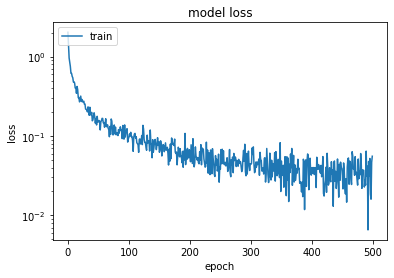

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize/0\0_nt1_20210626-090405.jpg 0 NaN
ziffer_sortiert_resize/2\0_ht7_20210627-205116.jpg 2 NaN
ziffer_sortiert_resize/2\0_ht7_20210627-222355.jpg 2 NaN
ziffer_sortiert_resize/2\10_dig6_20210726-190157.jpg 2 NaN
ziffer_sortiert_resize/4\10_dig4_20210709-181251.jpg 4 NaN
ziffer_sortiert_resize/4\4_dig6_20210724-184309.jpg 4 NaN
ziffer_sortiert_resize/5\3_dig6_20210723-134707.jpg 5 NaN
ziffer_sortiert_resize/6\3_dig4_20210722-224727.jpg 6 8
ziffer_sortiert_resize/7\10_dig6_20210727-150532.jpg 7 NaN


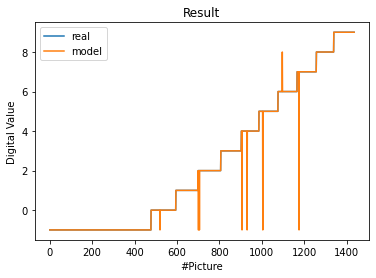

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []
only_deviation = True

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))
        if classes == -1: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp69kxmowv\assets


356604

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpqfyxhfdj\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpqfyxhfdj\assets


dig1110s2q.tflite


98512

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.